# This notebook is designed to try and create heat maps for h-abstraction reactions on biofules

In [61]:
from rmgpy.molecule import Molecule, Bond, Atom
import rdkit
import inspect
from rmgpy.qm.molecule import QMMolecule, Geometry
from rmgpy.qm.main import QMSettings

%matplotlib inline

import matplotlib
import numpy as np
import sympy
import matplotlib.pyplot as plt
from matplotlib.collections import EllipseCollection 


6
-3.45 -1.39888101103e-14 0.0
6
-1.95 -7.66053886991e-15 0.0
6
-1.2 1.29903810568 0.0
8
0.3 1.29903810568 0.0
6
1.05 2.59807621135 0.0
6
2.55 2.59807621135 0.0
6
-1.2 -1.29903810568 0.0
6
0.3 -1.29903810568 0.0
6
1.05 -2.59807621135 0.0
6
2.55 -2.59807621135 0.0
0 1 SINGLE
1 2 SINGLE
2 3 SINGLE
3 4 SINGLE
4 5 SINGLE
1 6 SINGLE
6 7 SINGLE
7 8 SINGLE
8 9 SINGLE


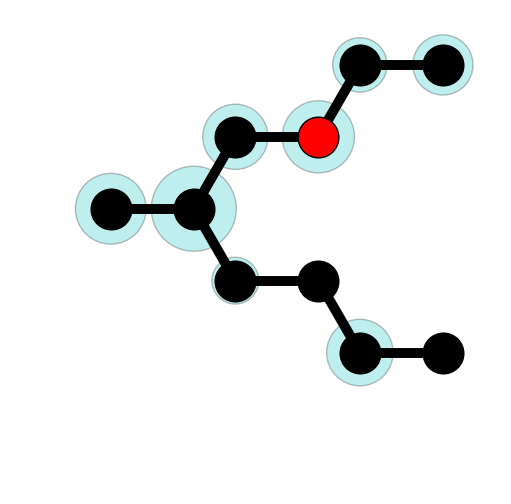

In [62]:

smiles = "CC(COCC)CCCC"
try:
    rdmol = rdkit.Chem.AllChem.MolFromSmiles(smiles)
except:
    rdmol = rdkit.Chem.AllChem.MolFromInchi(smiles)
rdmol.Compute2DCoords()
tup = rdmol.GetConformers()
rdconformer = tup[0]
rates = np.random.rand(rdconformer.GetNumAtoms())*4000 #figure out how to get rates
#for atom in rdmol.Atoms:
#igure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
fig, ax = plt.subplots(figsize=(6,6), dpi=120)

x=[]
y=[]


for i in range(rdconformer.GetNumAtoms()):
    print rdmol.GetAtoms()[i].GetAtomicNum()
    print rdconformer.GetAtomPosition(i).x, rdconformer.GetAtomPosition(i).y, rdconformer.GetAtomPosition(i).z
    x.append(rdconformer.GetAtomPosition(i).x)
    y.append(rdconformer.GetAtomPosition(i).y)
    
ax.scatter(x,y, s=rates, c='c', alpha=0.25, zorder=0)
    
ax.set_aspect('equal')
lim = ax.get_xlim()
lim2 = ax.get_ylim()
if lim > lim2:
    lim = lim2
diff = abs(lim[0] - lim[1])
size = 12000 / (2*diff)
thick = 50./ ( diff)

minimum = np.min((ax.get_xlim(),ax.get_ylim()))
maximum = np.max((ax.get_xlim(),ax.get_ylim()))
    
    # ToDo: Fix for double, triple bonds

ax.set_xlim(minimum*1.2,maximum*1.2)
ax.set_ylim(minimum*1.2,maximum*1.2)


for bond in rdmol.GetBonds():
    print bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), bond.GetBondType()
    if str(bond.GetBondType()) == "SINGLE":
        new_x = [x[bond.GetBeginAtomIdx()], x[bond.GetEndAtomIdx()]]
        new_y = [y[bond.GetBeginAtomIdx()], y[bond.GetEndAtomIdx()]]
        plt.plot(new_x, new_y, "k", alpha=1,zorder=1, linewidth=thick)
    elif str(bond.GetBondType()) == "DOUBLE":
        rise = y[bond.GetBeginAtomIdx()] - y[bond.GetEndAtomIdx()]
        run = x[bond.GetBeginAtomIdx()] - x[bond.GetEndAtomIdx()]
        

        del_y = sympy.Symbol('del_y')
        try:
            a = sympy.solvers.solve(0.1**2 - (- (rise/run) * del_y)**2 - del_y**2, del_y)
            del_x = - (rise/run) * a[0]
            v_1 = 0.15 * del_x / (del_x**2 + a[0]**2)**0.5
            v_2 = 0.15 * a[0] / (del_x**2 + a[0]**2)**0.5
        except ZeroDivisionError:
            v_1 = 0.15
            v_2 = 0
            
        
    
        
        new_x = [x[bond.GetBeginAtomIdx()] + v_1, x[bond.GetEndAtomIdx()] + v_1]
        new_y = [y[bond.GetBeginAtomIdx()] + v_2, y[bond.GetEndAtomIdx()] + v_2]
        newnew_x = [x[bond.GetBeginAtomIdx()] - v_1, x[bond.GetEndAtomIdx()] - v_1]
        newnew_y = [y[bond.GetBeginAtomIdx()] - v_2, y[bond.GetEndAtomIdx()] - v_2]
        plt.plot(new_x, new_y, "k", alpha=1, zorder=1, linewidth=thick)
        plt.plot(newnew_x, newnew_y, "k", alpha=1, zorder=1, linewidth=thick)
    elif str(bond.GetBondType()) == "TRIPLE":
        
        rise = y[bond.GetBeginAtomIdx()] - y[bond.GetEndAtomIdx()]
        run = x[bond.GetBeginAtomIdx()] - x[bond.GetEndAtomIdx()]
        

        del_y = sympy.Symbol('del_y')
        a = sympy.solvers.solve(0.1**2 - (- (rise/run) * del_y)**2 - del_y**2, del_y)
        del_x = - (rise/run) * a[0]
        dell_x = - (rise/run) * a[1]
        v_1 = 0.24 * del_x / (del_x**2 + a[0]**2)**0.5
        v_2 = 0.24 * a[0] / (del_x**2 + a[0]**2)**0.5
        
        new_x = [x[bond.GetBeginAtomIdx()], x[bond.GetEndAtomIdx()]]
        new_y = [y[bond.GetBeginAtomIdx()], y[bond.GetEndAtomIdx()]]
        newnew_x = [x[bond.GetBeginAtomIdx()] + v_1, x[bond.GetEndAtomIdx()] + v_1]
        newnew_y = [y[bond.GetBeginAtomIdx()] + v_2, y[bond.GetEndAtomIdx()] + v_2]
        newnewnew_x = [x[bond.GetBeginAtomIdx()] - v_1, x[bond.GetEndAtomIdx()] - v_1]
        newnewnew_y = [y[bond.GetBeginAtomIdx()] - v_2, y[bond.GetEndAtomIdx()] - v_2]
        plt.plot(new_x, new_y, "k", alpha=1, zorder=1, linewidth=thick)
        plt.plot(newnew_x, newnew_y, "k", alpha=1, zorder=1, linewidth=thick)
        plt.plot(newnewnew_x, newnewnew_y, "k", alpha=1, zorder=1, linewidth=thick)
        
    
    


plt.axis("off")


for i in range(rdconformer.GetNumAtoms()):
    if rdmol.GetAtoms()[i].GetAtomicNum() == 6:
        plt.scatter(rdconformer.GetAtomPosition(i).x, rdconformer.GetAtomPosition(i).y, c="k", s=size, alpha=1, zorder=10)
    elif rdmol.GetAtoms()[i].GetAtomicNum() == 7:
        plt.scatter(rdconformer.GetAtomPosition(i).x, rdconformer.GetAtomPosition(i).y, c="b", s=size, alpha=1, zorder=10)
    elif rdmol.GetAtoms()[i].GetAtomicNum() == 8:
        plt.scatter(rdconformer.GetAtomPosition(i).x, rdconformer.GetAtomPosition(i).y, c="r", s=size, alpha=1, zorder=10)




In [81]:
list_of_smiles = [
    "CC(C)CC(C)(C)C",
    "CCCCC(C)CC",
    "CCC(C)CC(C)C",
    "CCC(C)(C)O",
    "OCC(C)CCC",
    "CCCC(C)C=C(C)C",
    "CC1CCCC1",
    "C=C\C(=C\CCC(=C)C)C",
    "CC1=CC=C(C)C=C1",
    "CC(C)CC(=O)CC(C)C",
    "CC(C)CC(C)C(=O)C",
    "CC(C)(C)OCC(CO)OC(C)(C)C",
    "CCC(CC)OC(C)C",
    "CC1=CCC2CC1C2(C)C",
    "CC(C)CCOC(C)=O",
    "CCOC(=O)C(C)C",
    "CC1=CCCC1=O",
    "CCCCCC1CCC(C)O1",
    "CCCCC=C(C)C",
    "CCCC=CC(C)C",
    "CCC=CCC(C)C",
    "CC=CCCC(C)C",
    "C=CCCCC(C)C"
]

CC(C)CC(C)(C)C
6
-2.75378960943 0.865259520023 0.0
6
-1.46064202325 0.105148133217 0.0
6
-1.47234400084 -1.39480622066 0.0
6
-0.155792459478 0.84499110029 0.0
6
1.1373551267 0.0848797134842 0.0
6
1.89746651351 1.37802729967 0.0
6
0.377243739898 -1.2082678727 0.0
6
2.43050271289 -0.675231673322 0.0
0 1 SINGLE
1 2 SINGLE
1 3 SINGLE
3 4 SINGLE
4 5 SINGLE
4 6 SINGLE
4 7 SINGLE
CCCCC(C)CC
6
3.83863476748 0.698240196403 0.0
6
2.74274396459 -0.325978212012 0.0
6
1.30779940243 0.11098185886 0.0
6
0.21190859954 -0.913236549554 0.0
6
-1.22303596262 -0.476276478682 0.0
6
-2.31892676551 -1.5004948871 0.0
6
-1.56208972188 0.984902000604 0.0
6
-2.99703428404 1.42186207148 0.0
0 1 SINGLE
1 2 SINGLE
2 3 SINGLE
3 4 SINGLE
4 5 SINGLE
4 6 SINGLE
6 7 SINGLE
CCC(C)CC(C)C
6
2.79063942537 1.27836090272 0.0
6
2.33697580024 -0.151390584514 0.0
6
0.871942878641 -0.473382104001 0.0
6
0.418279253518 -1.90313359123 0.0
6
-0.139426417839 0.634377863744 0.0
6
-1.60445933944 0.312386344257 0.0
6
-2.61582863592 1.4201

/Users/nathan/anaconda/envs/rmg_env/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


6
-4.25509521805 -0.186519932815 0.0
6
-2.89475894553 0.44552850335 0.0
6
-1.66722080712 -0.416533048262 0.0
6
-0.306884534601 0.215515387903 0.0
6
0.920653603802 -0.646546163709 0.0
6
2.28098987632 -0.0144977275442 0.0
6
3.50852801473 -0.876559279156 0.0
6
2.41378801045 1.47961226023 0.0
0 1 SINGLE
1 2 SINGLE
2 3 DOUBLE
3 4 SINGLE
4 5 SINGLE
5 6 SINGLE
5 7 SINGLE
CC=CCCC(C)C
6
-4.25509521805 -0.186519932815 0.0
6
-2.89475894553 0.44552850335 0.0
6
-1.66722080712 -0.416533048262 0.0
6
-0.306884534601 0.215515387903 0.0
6
0.920653603802 -0.646546163709 0.0
6
2.28098987632 -0.0144977275442 0.0
6
3.50852801473 -0.876559279156 0.0
6
2.41378801045 1.47961226023 0.0
0 1 SINGLE
1 2 DOUBLE
2 3 SINGLE
3 4 SINGLE
4 5 SINGLE
5 6 SINGLE
5 7 SINGLE
C=CCCCC(C)C
6
-4.25509521805 -0.186519932815 0.0
6
-2.89475894553 0.44552850335 0.0
6
-1.66722080712 -0.416533048262 0.0
6
-0.306884534601 0.215515387903 0.0
6
0.920653603802 -0.646546163709 0.0
6
2.28098987632 -0.0144977275442 0.0
6
3.50852801473 -0.876

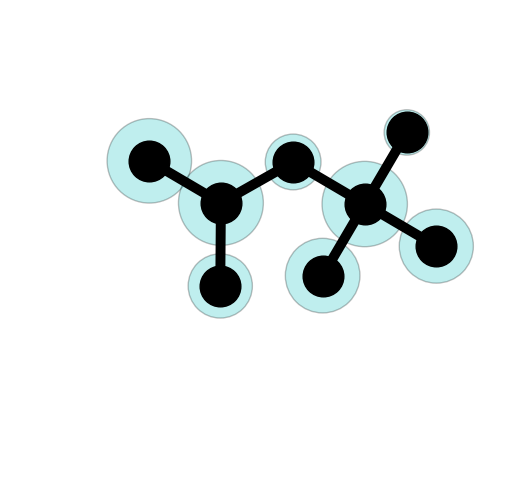

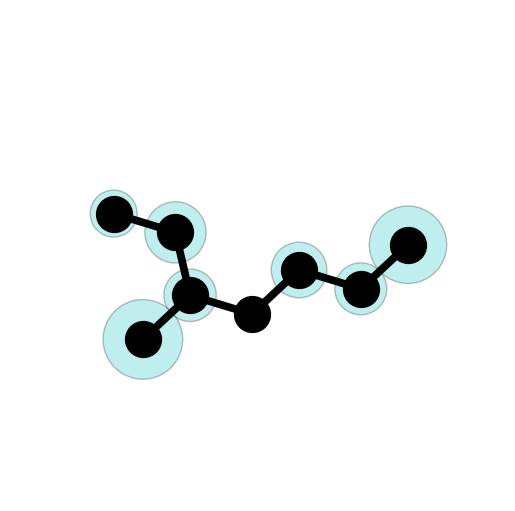

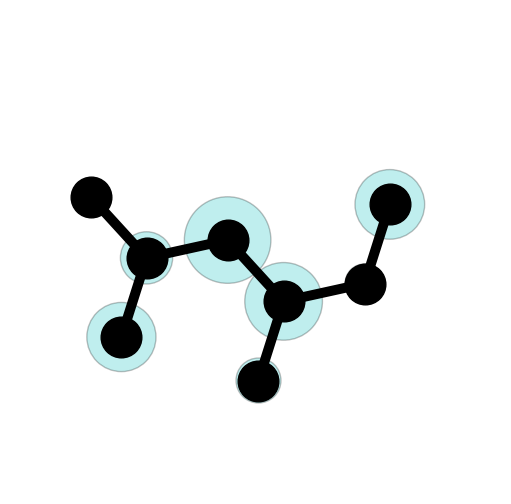

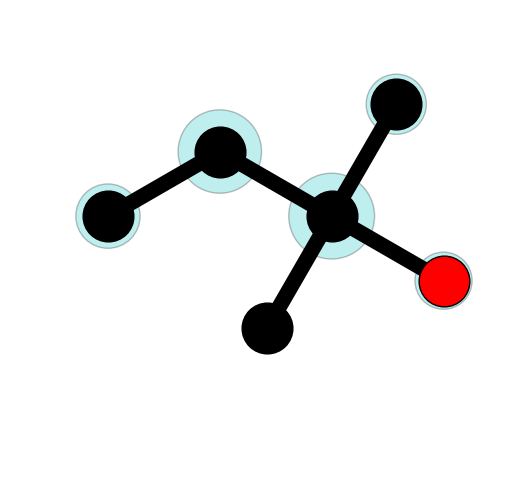

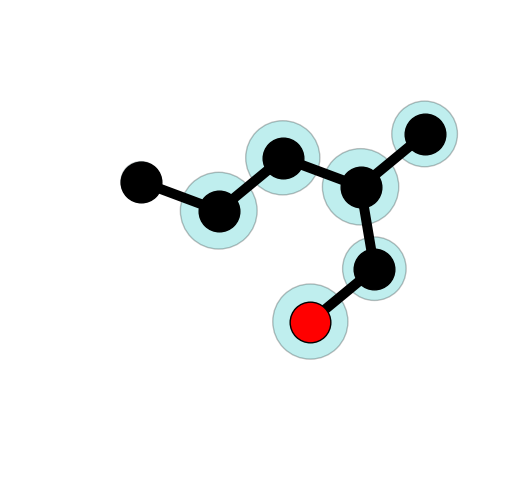

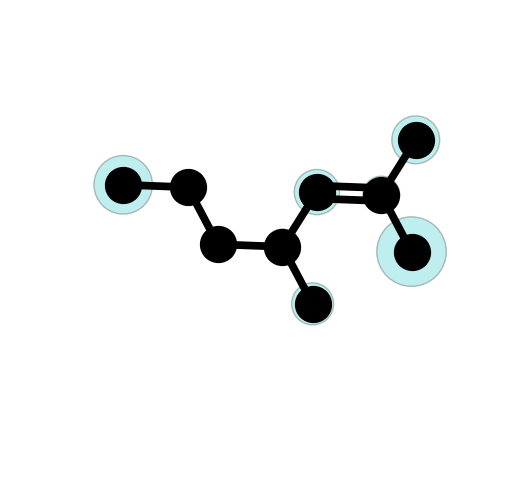

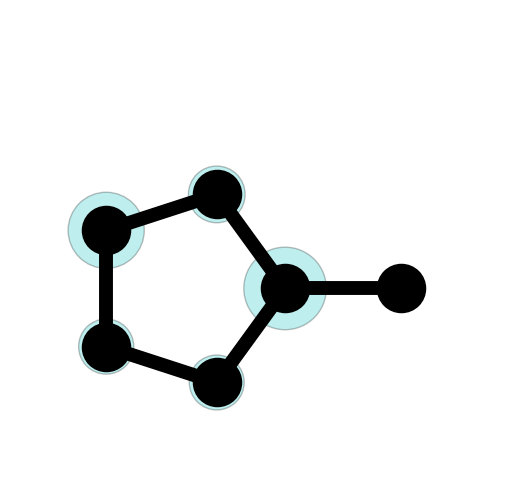

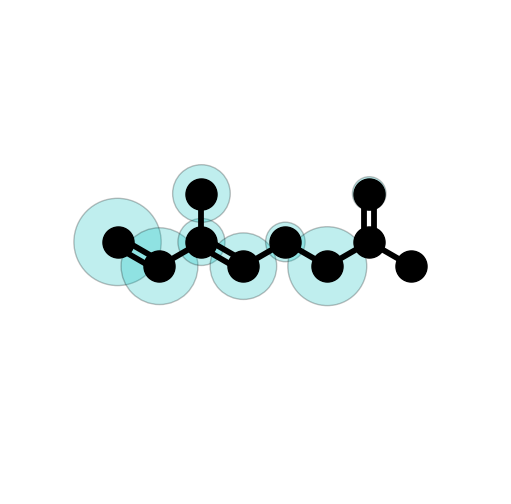

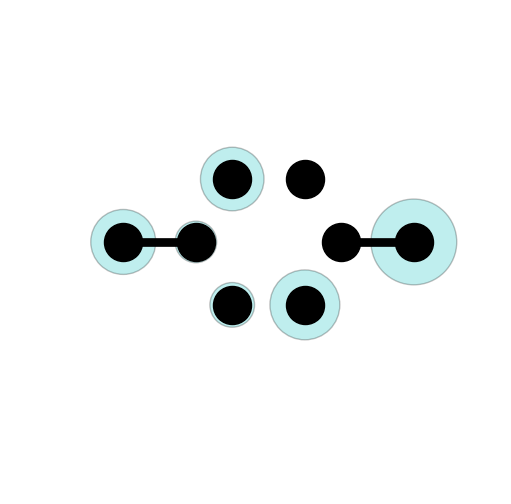

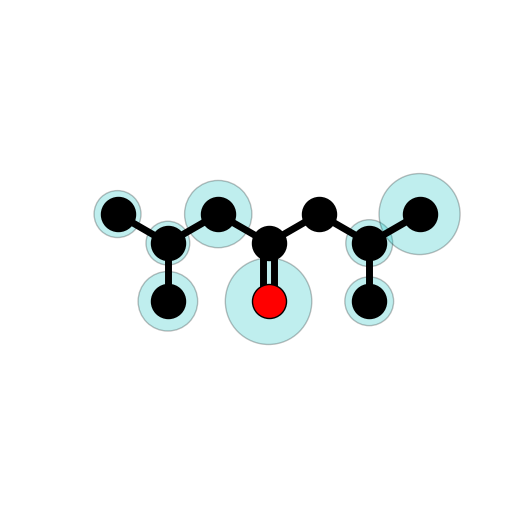

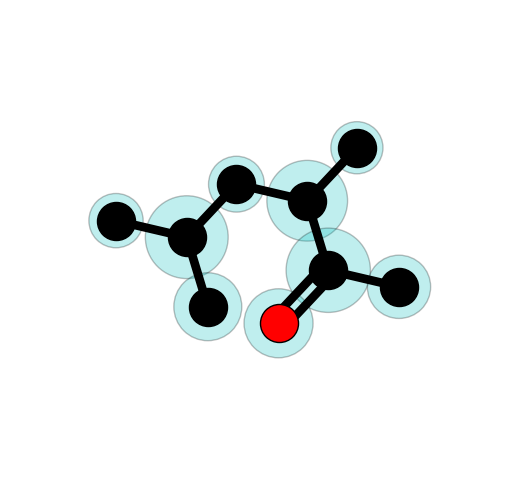

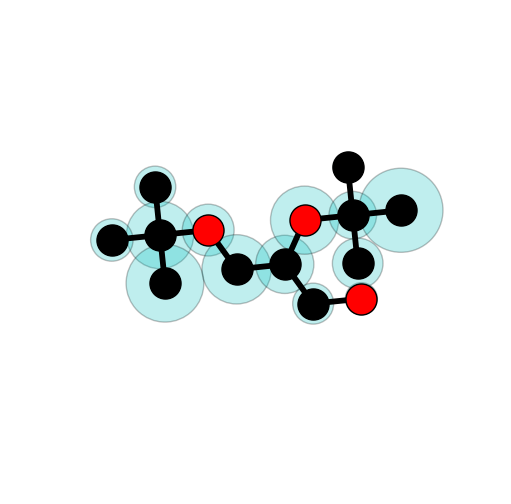

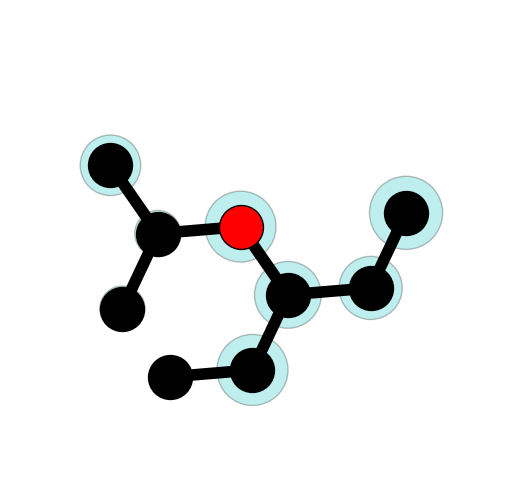

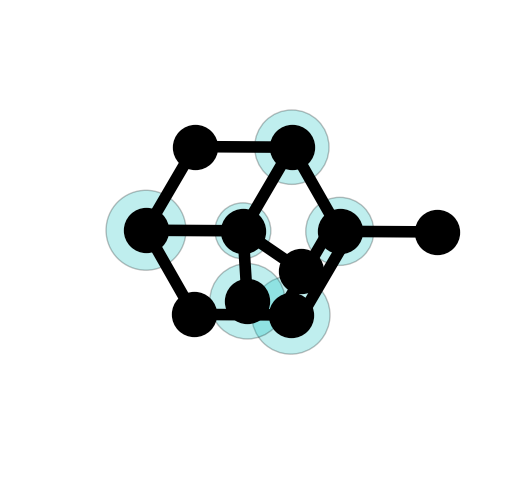

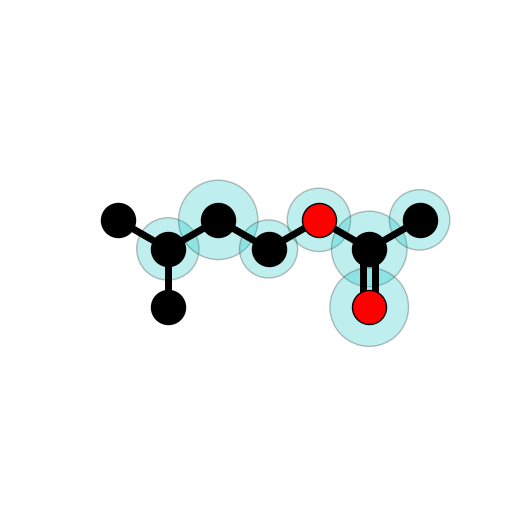

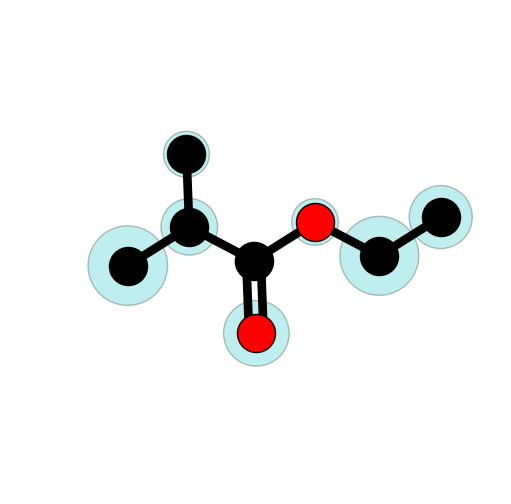

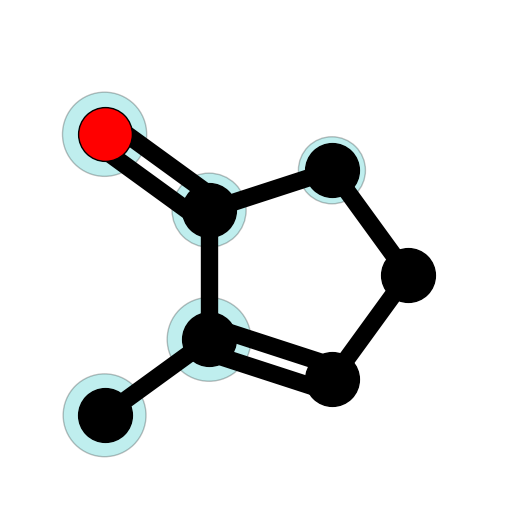

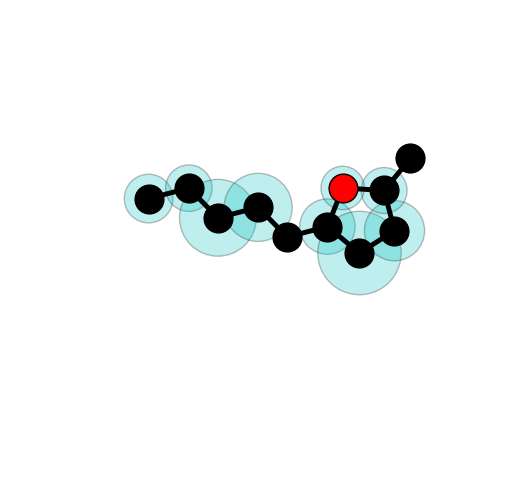

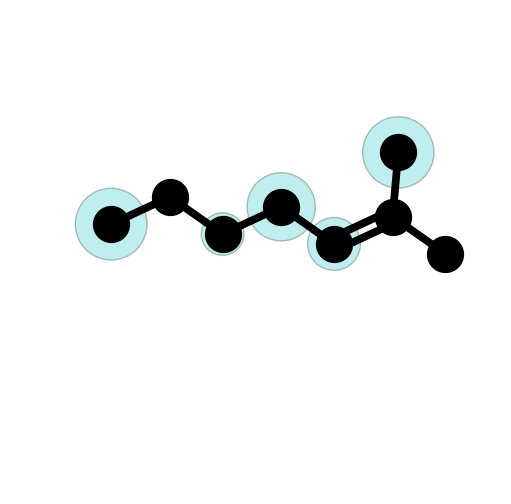

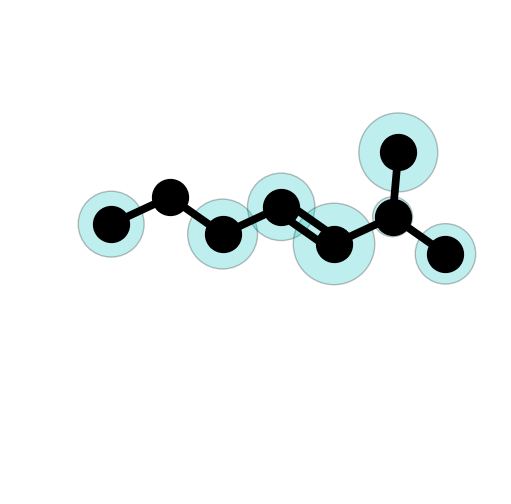

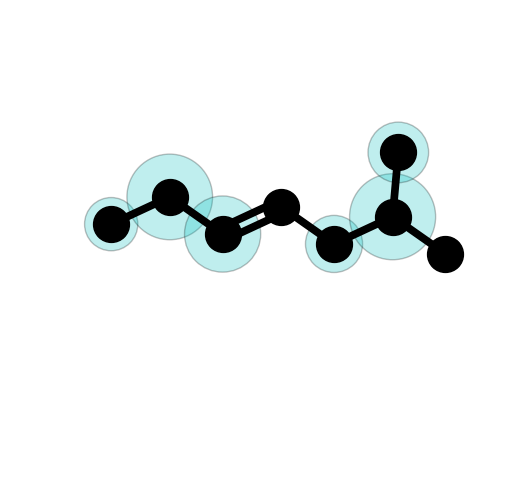

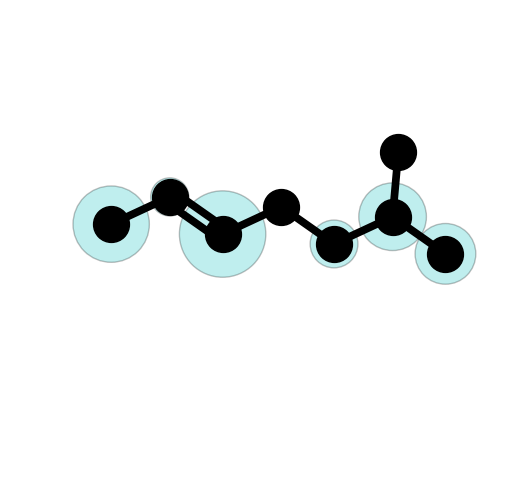

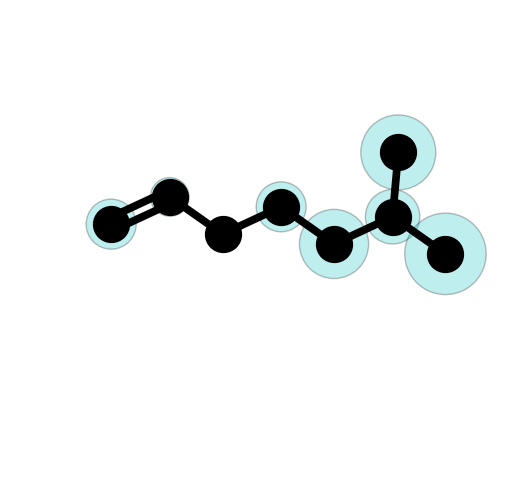

In [82]:
for smiles in list_of_smiles:
    print smiles
    
    rdmol = rdkit.Chem.AllChem.MolFromSmiles(smiles)
    rdmol.Compute2DCoords()
    tup = rdmol.GetConformers()
    rdconformer = tup[0]
    rates = np.random.rand(rdconformer.GetNumAtoms())*4000 #figure out how to get rates
    #for atom in rdmol.Atoms:
    #igure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    fig, ax = plt.subplots(figsize=(6,6), dpi=120)

    x=[]
    y=[]


    for i in range(rdconformer.GetNumAtoms()):
        print rdmol.GetAtoms()[i].GetAtomicNum()
        print rdconformer.GetAtomPosition(i).x, rdconformer.GetAtomPosition(i).y, rdconformer.GetAtomPosition(i).z
        x.append(rdconformer.GetAtomPosition(i).x)
        y.append(rdconformer.GetAtomPosition(i).y)

    ax.scatter(x,y, s=rates, c='c', alpha=0.25, zorder=0)

    ax.set_aspect('equal')
    lim = ax.get_xlim()
    lim2 = ax.get_ylim()
    if lim > lim2:
        lim = lim2
    diff = abs(lim[0] - lim[1])
    size = 12000 / (2*diff)
    thick = 50./ ( diff)

    minimum = np.min((ax.get_xlim(),ax.get_ylim()))
    maximum = np.max((ax.get_xlim(),ax.get_ylim()))

        # ToDo: Fix for double, triple bonds

    ax.set_xlim(minimum*1.2,maximum*1.2)
    ax.set_ylim(minimum*1.2,maximum*1.2)


    for bond in rdmol.GetBonds():
        print bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), bond.GetBondType()
        if str(bond.GetBondType()) == "SINGLE":
            new_x = [x[bond.GetBeginAtomIdx()], x[bond.GetEndAtomIdx()]]
            new_y = [y[bond.GetBeginAtomIdx()], y[bond.GetEndAtomIdx()]]
            plt.plot(new_x, new_y, "k", alpha=1,zorder=1, linewidth=thick)
        elif str(bond.GetBondType()) == "DOUBLE":
            rise = y[bond.GetBeginAtomIdx()] - y[bond.GetEndAtomIdx()]
            run = x[bond.GetBeginAtomIdx()] - x[bond.GetEndAtomIdx()]


            del_y = sympy.Symbol('del_y')
            try:
                a = sympy.solvers.solve(0.1**2 - (- (rise/run) * del_y)**2 - del_y**2, del_y)
                del_x = - (rise/run) * a[0]
                v_1 = 0.15 * del_x / (del_x**2 + a[0]**2)**0.5
                v_2 = 0.15 * a[0] / (del_x**2 + a[0]**2)**0.5
            except ZeroDivisionError:
                v_1 = 0.15
                v_2 = 0




            new_x = [x[bond.GetBeginAtomIdx()] + v_1, x[bond.GetEndAtomIdx()] + v_1]
            new_y = [y[bond.GetBeginAtomIdx()] + v_2, y[bond.GetEndAtomIdx()] + v_2]
            newnew_x = [x[bond.GetBeginAtomIdx()] - v_1, x[bond.GetEndAtomIdx()] - v_1]
            newnew_y = [y[bond.GetBeginAtomIdx()] - v_2, y[bond.GetEndAtomIdx()] - v_2]
            plt.plot(new_x, new_y, "k", alpha=1, zorder=1, linewidth=thick)
            plt.plot(newnew_x, newnew_y, "k", alpha=1, zorder=1, linewidth=thick)
        elif str(bond.GetBondType()) == "TRIPLE":

            rise = y[bond.GetBeginAtomIdx()] - y[bond.GetEndAtomIdx()]
            run = x[bond.GetBeginAtomIdx()] - x[bond.GetEndAtomIdx()]


            del_y = sympy.Symbol('del_y')
            a = sympy.solvers.solve(0.1**2 - (- (rise/run) * del_y)**2 - del_y**2, del_y)
            del_x = - (rise/run) * a[0]
            dell_x = - (rise/run) * a[1]
            v_1 = 0.24 * del_x / (del_x**2 + a[0]**2)**0.5
            v_2 = 0.24 * a[0] / (del_x**2 + a[0]**2)**0.5

            new_x = [x[bond.GetBeginAtomIdx()], x[bond.GetEndAtomIdx()]]
            new_y = [y[bond.GetBeginAtomIdx()], y[bond.GetEndAtomIdx()]]
            newnew_x = [x[bond.GetBeginAtomIdx()] + v_1, x[bond.GetEndAtomIdx()] + v_1]
            newnew_y = [y[bond.GetBeginAtomIdx()] + v_2, y[bond.GetEndAtomIdx()] + v_2]
            newnewnew_x = [x[bond.GetBeginAtomIdx()] - v_1, x[bond.GetEndAtomIdx()] - v_1]
            newnewnew_y = [y[bond.GetBeginAtomIdx()] - v_2, y[bond.GetEndAtomIdx()] - v_2]
            plt.plot(new_x, new_y, "k", alpha=1, zorder=1, linewidth=thick)
            plt.plot(newnew_x, newnew_y, "k", alpha=1, zorder=1, linewidth=thick)
            plt.plot(newnewnew_x, newnewnew_y, "k", alpha=1, zorder=1, linewidth=thick)





    plt.axis("off")


    for i in range(rdconformer.GetNumAtoms()):
        if rdmol.GetAtoms()[i].GetAtomicNum() == 6:
            plt.scatter(rdconformer.GetAtomPosition(i).x, rdconformer.GetAtomPosition(i).y, c="k", s=size, alpha=1, zorder=10)
        elif rdmol.GetAtoms()[i].GetAtomicNum() == 7:
            plt.scatter(rdconformer.GetAtomPosition(i).x, rdconformer.GetAtomPosition(i).y, c="b", s=size, alpha=1, zorder=10)
        elif rdmol.GetAtoms()[i].GetAtomicNum() == 8:
            plt.scatter(rdconformer.GetAtomPosition(i).x, rdconformer.GetAtomPosition(i).y, c="r", s=size, alpha=1, zorder=10)




In [87]:
smiles = "CC(C)CC(C)(C)C"
try:
    rdmol = rdkit.Chem.AllChem.MolFromSmiles(smiles)
except:
    rdmol = rdkit.Chem.AllChem.MolFromInchi(smiles)
    smiles = rdkit.Chem.AllChem.MolToSmiles(mol)
    rdmol = rdkit.Chem.AllChem.MolFromInchi(smiles)
rdmol.Compute2DCoords()
tup = rdmol.GetConformers()
rdconformer = tup[0]

for atom in rdmol.GetAtoms():
    rdmol.

In [80]:
mol = rdkit.Chem.AllChem.MolFromInchi("InChI=1S/C6H12/c1-6-4-2-3-5-6/h6H,2-5H2,1H3")
rdkit.Chem.AllChem.MolToSmiles(mol)

'CC1CCCC1'

In [33]:
v_1 = 0.1 * del_x / (del_x**2 + a[0]**2)**0.5
v_2 = 0.1 * a[0] / (del_x**2 + a[0]**2)**0.5





(-8.0, 6.0)

In [82]:
diff

7.0

In [66]:
500 * 14 / 0.5

14000.0

In [67]:
14000/28

500

In [21]:
5./8

0.625

In [172]:
Mol = Molecule(SMILES="CC(C)CC(C)C(=O)C")
smilesList =[]
for i in range(len(Mol.__getAtoms())):
    Moll = Mol.copy(Mol)
    atom = Moll.__getAtoms()[i]
    for atom2 in atom.bonds:
        print atom2
        if atom2.isHydrogen():
            Moll.removeAtom(atom2)
            atom.incrementRadical()
            smiles = Moll.toSMILES()
            print smiles
            if smiles not in smilesList:
                smilesList.append(smiles)
        break
                
                
                
         
    #print Mol.toSMILES()

C
C
H
[CH2]C(C)CC(C)C(C)=O
C
C
H
[CH2]C(CC(C)C)C(C)=O
C
C
H
[CH2]C(=O)C(C)CC(C)C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C


In [ ]:
        print atom.decrementRadical

In [166]:
for smiles in smilesList:
    mol = Molecule(SMILES=smiles)
    print mol

<Molecule "[CH2]C(C)CC(C)C(C)=O">
<Molecule "[CH2]C(CC(C)C)C(C)=O">


In [186]:
mol = rdkit.Chem.AllChem.MolFromSmiles("CCCC")
mol2 = rdkit.Chem.AllChem.MolFromSmiles("[CH2]CCC")


In [189]:
for i in range(len(mol.GetAtoms())):
    print i
    if mol.GetAtoms()[i].GetNumRadicalElectrons() != mol2.GetAtoms()[i].GetNumRadicalElectrons():
        print 
    

0
oMG
1
2
3
